# 1. Data Collection

In [2]:
!pip install yfinance
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install tensorflow
!pip install xgboost
!pip install stable_baselines3
!pip install shimmy

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np

# --- Phase 1: Data Acquisition and Preprocessing ---

# 1. Set up Environment & Define Parameters
# List of assets for the portfolio, including the VIX index as a macro factor.
tickers = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL',  # Stocks
    'SPY', 'QQQ',                             # ETFs
    'BTC-USD', 'ETH-USD',                     # Cryptocurrencies
    '^VIX'                                    # VIX Index
]
start_date = '2018-09-01'
end_date = '2025-09-01'

print("--- Step 1: Initiating Data Download ---")
print(f"Assets: {tickers}")
print(f"Time Period: {start_date} to {end_date}\n")


# 2. Download Data from Yahoo Finance
# The yfinance library now defaults to auto_adjust=True, which provides the adjusted prices
# directly in the 'Close' column. We will download all columns and then select 'Close'.
try:
    # Set auto_adjust=True explicitly to ensure we get adjusted prices and suppress the warning.
    data_full = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
    if data_full.empty:
        raise ValueError("No data downloaded. Check tickers and date range.")

    data = data_full['Close'] # Select the 'Close' column which contains the adjusted prices
    print("--- Step 2: Data Download Successful ---\n")
except Exception as e:
    print(f"An error occurred during data download: {e}")
    data = pd.DataFrame() # Create an empty dataframe to avoid further errors

if not data.empty:
    # 3. Data Cleaning
    print("--- Step 3: Data Cleaning ---")
    # Check for missing values before cleaning.
    print("Missing values before cleaning:")
    print(data.isnull().sum())

    # Forward-fill is a common method for time-series data to handle missing values.
    # It propagates the last valid observation forward.
    data.fillna(method='ffill', inplace=True)

    # Some early data points might still be NaN if they occur before the first valid entry.
    # We will back-fill those to ensure the dataset is fully clean.
    data.fillna(method='bfill', inplace=True)


    print("\nMissing values after cleaning:")
    print(data.isnull().sum())
    print("\nData cleaning complete.\n")


    # 4. Train-Test Split
    print("--- Step 4: Splitting Data into Training and Testing Sets ---")
    # We will use an 80/20 split. The data is split chronologically to prevent lookahead bias.
    split_ratio = 0.8
    split_index = int(len(data) * split_ratio)

    train_data = data.iloc[:split_index]
    test_data = data.iloc[split_index:]

    print(f"Total data points: {len(data)}")
    print(f"Training data points: {len(train_data)}")
    print(f"Testing data points: {len(test_data)}\n")

    print("--- Phase 1 Complete: Data is ready for Feature Engineering ---\n")

    # Display a sample of the final datasets
    print("--- Sample of Full Cleaned Dataset ---")
    print(data.head())
    print("\n" + "="*50 + "\n")
    print("--- Sample of Training Data ---")
    print(train_data.head())
    print("\n" + "="*50 + "\n")
    print("--- Sample of Test Data ---")
    print(test_data.head())



--- Step 1: Initiating Data Download ---
Assets: ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'SPY', 'QQQ', 'BTC-USD', 'ETH-USD', '^VIX']
Time Period: 2018-09-01 to 2025-09-01



[*********************100%***********************]  10 of 10 completed

--- Step 2: Data Download Successful ---

--- Step 3: Data Cleaning ---
Missing values before cleaning:
Ticker
AAPL       800
AMZN       800
BTC-USD      0
ETH-USD      0
GOOGL      800
MSFT       800
NVDA       800
QQQ        800
SPY        800
^VIX       800
dtype: int64

Missing values after cleaning:
Ticker
AAPL       0
AMZN       0
BTC-USD    0
ETH-USD    0
GOOGL      0
MSFT       0
NVDA       0
QQQ        0
SPY        0
^VIX       0
dtype: int64

Data cleaning complete.

--- Step 4: Splitting Data into Training and Testing Sets ---
Total data points: 2557
Training data points: 2045
Testing data points: 512

--- Phase 1 Complete: Data is ready for Feature Engineering ---

--- Sample of Full Cleaned Dataset ---
Ticker           AAPL        AMZN      BTC-USD     ETH-USD      GOOGL  \
Date                                                                    
2018-09-01  54.146664  101.975502  7193.250000  295.341003  60.150635   
2018-09-02  54.146664  101.975502  7272.720215  294.3710


/tmp/ipython-input-684097172.py:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/tmp/ipython-input-684097172.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(method='ffill', inplace=True)
/tmp/ipython-input-684097172.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
/tmp/ipython-input-684097172.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

# 2. Feature Engineering

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- Phase 2: Feature Engineering ---

# This script assumes 'train_data' and 'test_data' from Phase 1 are available in memory.
# If not, you would first run the phase_1_data_preprocessing.py script.
# For demonstration, we will re-run the necessary parts of Phase 1 if variables are not found.

try:
    _ = data # Check if the full data from Phase 1 exists
    print("--- Using existing data from Phase 1 ---\n")
except NameError:
    print("--- Data not found. Re-running essential parts of Phase 1 ---")
    # This is a fallback to make the script runnable standalone for testing.
    import yfinance as yf
    tickers = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'SPY', 'QQQ', 'BTC-USD', 'ETH-USD', '^VIX']
    start_date = '2018-09-01'
    end_date = '2025-09-01'
    data_full = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
    data = data_full['Close']
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    print("--- Data reloaded and split successfully ---\n")


# 1. Calculate Returns
print("--- Step 1: Calculating Daily Returns ---")
# We calculate returns for all assets except VIX, which is a volatility index, not a traded asset price.
asset_tickers = [t for t in ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'SPY', 'QQQ', 'BTC-USD', 'ETH-USD', '^VIX'] if t != '^VIX']
returns = data[asset_tickers].pct_change()
print("Returns calculated.\n")


# 2. Create Features
print("--- Step 2: Generating Technical Features ---")

# Isolate VIX data to be used as a feature
vix_data = data[['^VIX']]

# Function to calculate Relative Strength Index (RSI)
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Create a master DataFrame to hold all features
all_features = pd.DataFrame(index=data.index)

# Loop through each asset to create its specific features
for asset in asset_tickers:
    # Lagged returns
    all_features[f'{asset}_lag1'] = returns[asset].shift(1)
    all_features[f'{asset}_lag3'] = returns[asset].shift(3)
    all_features[f'{asset}_lag5'] = returns[asset].shift(5)

    # Rolling volatility (20-day standard deviation of returns)
    all_features[f'{asset}_volatility'] = returns[asset].rolling(window=20).std()

    # RSI (14-day)
    all_features[f'{asset}_rsi'] = calculate_rsi(data[asset], period=14)

print("Technical features generated for all assets.\n")


# 3. Incorporate Macro Factor (VIX)
print("--- Step 3: Incorporating VIX as a Macro Feature ---")
# We add the VIX value itself as a feature.
all_features['VIX'] = vix_data['^VIX']
print("VIX data incorporated.\n")

# Clean up any NaN values created by rolling calculations and shifts
all_features.dropna(inplace=True)

# Align returns data with the cleaned feature data index
aligned_returns = returns.loc[all_features.index]


# 4. Split Features and Returns into Train/Test Sets
print("--- Step 4: Splitting Data into Training and Testing Sets ---")
split_ratio = 0.8
split_index = int(len(all_features) * split_ratio)

train_features = all_features.iloc[:split_index]
test_features = all_features.iloc[split_index:]

train_returns = aligned_returns.iloc[:split_index]
test_returns = aligned_returns.iloc[split_index:]

print(f"Total feature data points after cleaning: {len(all_features)}")
print(f"Training features data points: {len(train_features)}")
print(f"Testing features data points: {len(test_features)}\n")


# 5. Scale Data
print("--- Step 5: Scaling All Features ---")
scaler = MinMaxScaler()

# Fit the scaler ONLY on the training data to prevent data leakage from the test set.
scaled_train_features = scaler.fit_transform(train_features)
# Transform the test data using the scaler that was fitted on the training data.
scaled_test_features = scaler.transform(test_features)

# Convert scaled arrays back to DataFrames for clarity
scaled_train_features_df = pd.DataFrame(scaled_train_features, index=train_features.index, columns=train_features.columns)
scaled_test_features_df = pd.DataFrame(scaled_test_features, index=test_features.index, columns=test_features.columns)

print("Features have been scaled successfully.\n")
print("--- Phase 2 Complete: Features are ready for all models (LSTM, XGBoost, Random Forest) ---\n")


# Display a sample of the final scaled feature datasets
print("--- Shape of Final Datasets ---")
print(f"Scaled Training Features Shape: {scaled_train_features_df.shape}")
print(f"Scaled Testing Features Shape:  {scaled_test_features_df.shape}")
print(f"Training Returns Shape:         {train_returns.shape}")
print(f"Testing Returns Shape:          {test_returns.shape}")
print("\n" + "="*50 + "\n")

print("--- Sample of Scaled Training Features ---")
print(scaled_train_features_df.head())
print("\n" + "="*50 + "\n")

print("--- Sample of Scaled Testing Features ---")
print(scaled_test_features_df.head())



--- Using existing data from Phase 1 ---

--- Step 1: Calculating Daily Returns ---
Returns calculated.

--- Step 2: Generating Technical Features ---
Technical features generated for all assets.

--- Step 3: Incorporating VIX as a Macro Feature ---
VIX data incorporated.

--- Step 4: Splitting Data into Training and Testing Sets ---
Total feature data points after cleaning: 2537
Training features data points: 2029
Testing features data points: 508

--- Step 5: Scaling All Features ---
Features have been scaled successfully.

--- Phase 2 Complete: Features are ready for all models (LSTM, XGBoost, Random Forest) ---

--- Shape of Final Datasets ---
Scaled Training Features Shape: (2029, 46)
Scaled Testing Features Shape:  (508, 46)
Training Returns Shape:         (2029, 9)
Testing Returns Shape:          (508, 9)


--- Sample of Scaled Training Features ---
            AAPL_lag1  AAPL_lag3  AAPL_lag5  AAPL_volatility  AAPL_rsi  \
Date                                                     

# Phase 3 : Training

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# --- Phase 3: Model Development ---

# This script assumes variables from Phase 2 are in memory.
# A fallback is included to make the script runnable standalone.

try:
    # Check if necessary variables from Phase 2 exist
    _ = scaled_train_features_df, train_returns, asset_tickers
    print("--- Using existing data from previous phases ---\n")
except NameError:
    print("--- Data not found. Re-running essential parts of previous phases ---")
    # This is a fallback to make the script runnable standalone for testing.
    import yfinance as yf
    tickers = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'SPY', 'QQQ', 'BTC-USD', 'ETH-USD', '^VIX']
    asset_tickers = [t for t in tickers if t != '^VIX']
    start_date = '2018-09-01'
    end_date = '2025-09-01'
    data_full = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
    data = data_full['Close']
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)

    returns = data[asset_tickers].pct_change()
    vix_data = data[['^VIX']]

    def calculate_rsi(series, period=14):
        delta = series.diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    all_features = pd.DataFrame(index=data.index)
    for asset in asset_tickers:
        all_features[f'{asset}_lag1'] = returns[asset].shift(1)
        all_features[f'{asset}_lag3'] = returns[asset].shift(3)
        all_features[f'{asset}_lag5'] = returns[asset].shift(5)
        all_features[f'{asset}_volatility'] = returns[asset].rolling(window=20).std()
        all_features[f'{asset}_rsi'] = calculate_rsi(data[asset], period=14)
    all_features['VIX'] = vix_data['^VIX']
    all_features.dropna(inplace=True)

    aligned_returns = returns.loc[all_features.index]
    split_index = int(len(all_features) * 0.8)
    train_features = all_features.iloc[:split_index]
    train_returns = aligned_returns.iloc[:split_index]

    scaler = MinMaxScaler()
    scaled_train_features = scaler.fit_transform(train_features)
    scaled_train_features_df = pd.DataFrame(scaled_train_features, index=train_features.index, columns=train_features.columns)
    print("--- Data reloaded and prepared successfully ---\n")


# --- Target Variable Preparation ---
# Our goal is to allocate weight to the asset that will perform best on the next day.
# The target (y) for each day is the asset with the highest return on the *next* day.
# We use .shift(-1) to look one day into the future.
y_train_series = train_returns.shift(-1).idxmax(axis=1).dropna()
# Align X and y by dropping the last row from X (since we can't calculate its future return)
X_train_df = scaled_train_features_df.loc[y_train_series.index]

# Convert asset names (strings) to integer labels for the models
y_train_labels = pd.Series(y_train_series.astype('category').cat.codes, index=y_train_series.index)


# --- Model 1: LSTM ---
print("--- Starting LSTM Model Training ---")

# Prepare data in sequences for the LSTM model
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 60
X_lstm, y_lstm = create_sequences(X_train_df, y_train_labels, TIME_STEPS)

# One-hot encode the target variable for the LSTM's categorical_crossentropy loss function
y_lstm_one_hot = to_categorical(y_lstm, num_classes=len(asset_tickers))

# Build the LSTM model architecture
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25, activation='relu'),
    # The output layer has one neuron for each asset. 'softmax' gives a probability distribution.
    Dense(units=len(asset_tickers), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Train the LSTM model
lstm_model.fit(X_lstm, y_lstm_one_hot, epochs=50, batch_size=32, validation_split=0.1, verbose=1)
print("\n--- LSTM Model Training Complete ---\n")


# --- Model 2: XGBoost ---
print("--- Starting XGBoost Model Training ---")
# XGBoost does not require data to be in sequences. It uses the 2D feature set directly.
# The labels for XGBoost are the integer codes we created earlier.
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # Outputs a probability for each class
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train_df, y_train_labels)
print("\n--- XGBoost Model Training Complete ---\n")


# --- Model 3: Random Forest ---
print("--- Starting Random Forest Model Training ---")
# Random Forest also works with the 2D feature set and integer labels.
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

rf_model.fit(X_train_df, y_train_labels)
print("\n--- Random Forest Model Training Complete ---\n")
print("--- Phase 3 Complete: All models are trained and ready for backtesting. ---")

--- Using existing data from previous phases ---

--- Starting LSTM Model Training ---


/tmp/ipython-input-2076179009.py:69: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  y_train_series = train_returns.shift(-1).idxmax(axis=1).dropna()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        19,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,109 (160.58 KB)

 Trainable params: 41,109 (160.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.2587 - loss: 2.0418 - val_accuracy: 0.2183 - val_loss: 1.8709
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.2374 - loss: 1.9423 - val_accuracy: 0.2183 - val_loss: 1.8884
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.2847 - loss: 1.9192 - val_accuracy: 0.2183 - val_loss: 1.8590
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.3016 - loss: 1.8746 - val_accuracy: 0.2183 - val_loss: 1.8748
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.2846 - loss: 1.8709 - val_accuracy: 0.2183 - val_loss: 1.8746
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.2894 - loss: 1.8660 - val_accuracy: 0.2183 - val_loss: 1.8764
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2975 - loss: 1.8687 - val_accuracy: 0.2183 - val_loss: 1.8749
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.2742 - loss: 1.8748 - val_accuracy: 0.2183 - v

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:28:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Model Training Complete ---

--- Starting Random Forest Model Training ---

--- Random Forest Model Training Complete ---

--- Phase 3 Complete: All models are trained and ready for backtesting. ---


# Phase 4 : Backtesting

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# --- Phase 4: Backtesting and Strategy Simulation ---

# This script assumes all models and data from Phase 3 are in memory.
# A fallback is included to make the script runnable standalone.

try:
    # Check if necessary variables from previous phases exist
    _ = (
        lstm_model, xgb_model, rf_model,
        scaled_test_features_df, test_returns,
        scaler, all_features, train_features,
        asset_tickers, TIME_STEPS
    )
    print("--- Using existing data and models from previous phases ---\n")
except NameError:
    print("--- Data or models not found. Re-running essential parts of previous phases ---")
    # This is a condensed fallback for standalone execution.
    # In a real notebook, you would run the scripts sequentially.
    # NOTE: This fallback will retrain the models, which takes time.
    exec(open('phase_1_data_preprocessing.py').read())
    exec(open('phase_2_feature_engineering.py').read())
    exec(open('phase_3_model_development.py').read())
    # Re-assign test variables as they might be local to the exec scope
    scaled_test_features_df = pd.DataFrame(scaler.transform(test_features), index=test_features.index, columns=test_features.columns)
    print("--- Environment re-initialized successfully ---\n")


# --- Backtesting Setup ---
print("--- Initializing Backtest ---")
# Transaction cost assumption (e.g., 0.1% or 10 basis points per trade)
TRANSACTION_COST = 0.001
# Create a DataFrame to store the daily returns of each strategy
portfolio_returns = pd.DataFrame(index=test_returns.index)

# --- 1. Benchmark Strategy: Equal Weight (1/N) Portfolio ---
print("Calculating Benchmark (Equal Weight) returns...")
num_assets = len(asset_tickers)
equal_weights = np.full(num_assets, 1/num_assets)
# The return is the dot product of the weights and the asset returns for that day.
portfolio_returns['Benchmark'] = test_returns.dot(equal_weights)
print("Benchmark returns calculated.\n")


# --- 2. Walk-Forward Backtest for ML Models ---
print("--- Starting Walk-Forward Backtest for ML Strategies ---")
# We will iterate through the test set day by day.

# Initialize empty lists to store daily returns for each strategy
lstm_daily_returns = []
xgb_daily_returns = []
rf_daily_returns = []

# Initialize the previous day's weights to None for transaction cost calculation
prev_weights_lstm = np.zeros(num_assets)
prev_weights_xgb = np.zeros(num_assets)
prev_weights_rf = np.zeros(num_assets)

# The main loop iterates from the first possible prediction day to the second to last day of the test set.
# We need to ensure we have enough historical data for the LSTM's sequence.
start_index = TIME_STEPS
for i in range(start_index, len(scaled_test_features_df)):
    # --- Data Preparation for this time step ---
    # For LSTM: Get the last `TIME_STEPS` days of feature data
    current_sequence = scaled_test_features_df.iloc[i-TIME_STEPS:i].values
    # Reshape for LSTM: (1 sample, TIME_STEPS, num_features)
    current_sequence_reshaped = np.reshape(current_sequence, (1, TIME_STEPS, current_sequence.shape[1]))

    # For XGBoost/Random Forest: Get the feature data for the most recent day
    current_features = scaled_test_features_df.iloc[[i-1]]

    # --- Prediction/Allocation for each model ---
    # The model predicts probabilities for the best asset for the *next* day (day i)

    # LSTM Prediction
    lstm_probs = lstm_model.predict(current_sequence_reshaped, verbose=0)[0]
    # Strategy: Go 100% into the asset with the highest predicted probability
    weights_lstm = np.zeros(num_assets)
    weights_lstm[np.argmax(lstm_probs)] = 1.0

    # XGBoost Prediction
    xgb_probs = xgb_model.predict_proba(current_features)[0]
    weights_xgb = np.zeros(num_assets)
    weights_xgb[np.argmax(xgb_probs)] = 1.0

    # Random Forest Prediction
    rf_probs = rf_model.predict_proba(current_features)[0]
    weights_rf = np.zeros(num_assets)
    weights_rf[np.argmax(rf_probs)] = 1.0

    # --- Calculate Portfolio Return for day i ---
    # Get the actual returns for the assets on day i
    actual_returns = test_returns.iloc[i]

    # Calculate portfolio return for each strategy
    ret_lstm = np.dot(weights_lstm, actual_returns)
    ret_xgb = np.dot(weights_xgb, actual_returns)
    ret_rf = np.dot(weights_rf, actual_returns)

    # --- Account for Transaction Costs ---
    # Cost is incurred based on the change in portfolio weights from the previous day
    turnover_lstm = np.sum(np.abs(weights_lstm - prev_weights_lstm))
    turnover_xgb = np.sum(np.abs(weights_xgb - prev_weights_xgb))
    turnover_rf = np.sum(np.abs(weights_rf - prev_weights_rf))

    ret_lstm -= turnover_lstm * TRANSACTION_COST
    ret_xgb -= turnover_xgb * TRANSACTION_COST
    ret_rf -= turnover_rf * TRANSACTION_COST

    # Append the net return for the day
    lstm_daily_returns.append(ret_lstm)
    xgb_daily_returns.append(ret_xgb)
    rf_daily_returns.append(ret_rf)

    # Update previous weights for the next iteration
    prev_weights_lstm = weights_lstm
    prev_weights_xgb = weights_xgb
    prev_weights_rf = weights_rf

    # Progress indicator
    if (i+1) % 100 == 0:
        print(f"Processed {i+1-start_index}/{len(scaled_test_features_df)-start_index} days...")

# --- Finalize Results ---
# The number of returns will be smaller than the test set size due to the initial sequence length.
# We need to align the returns with the correct dates in the main DataFrame.
returns_index = test_returns.index[start_index:]

portfolio_returns['LSTM'] = pd.Series(lstm_daily_returns, index=returns_index)
portfolio_returns['XGBoost'] = pd.Series(xgb_daily_returns, index=returns_index)
portfolio_returns['RandomForest'] = pd.Series(rf_daily_returns, index=returns_index)

# Drop any rows with NaN values that might have been created
portfolio_returns.dropna(inplace=True)

print("\n--- Backtesting Complete ---")
print("Daily returns for all strategies have been calculated.\n")

print("--- Sample of Strategy Daily Returns ---")
print(portfolio_returns.head())
print("\n" + "="*50 + "\n")
print("--- Final Portfolio Returns Shape ---")
print(portfolio_returns.shape)
print("\n--- Phase 4 Complete: Performance data is ready for analysis. ---")


--- Using existing data and models from previous phases ---

--- Initializing Backtest ---
Calculating Benchmark (Equal Weight) returns...
Benchmark returns calculated.

--- Starting Walk-Forward Backtest for ML Strategies ---
Processed 40/448 days...
Processed 140/448 days...
Processed 240/448 days...
Processed 340/448 days...
Processed 440/448 days...

--- Backtesting Complete ---
Daily returns for all strategies have been calculated.

--- Sample of Strategy Daily Returns ---
            Benchmark      LSTM   XGBoost  RandomForest
Date                                                   
2024-06-10   0.001298  0.006461  0.013976      0.013976
2024-06-11   0.002093 -0.007144  0.004863      0.000909
2024-06-12   0.015619  0.035481  0.033481      0.033481
2024-06-13  -0.003219  0.035224  0.035224      0.035224
2024-06-14   0.001974  0.017514 -0.010168      0.017514


--- Final Portfolio Returns Shape ---
(448, 4)

--- Phase 4 Complete: Performance data is ready for analysis. ---


# Phase 5: Evaluation

--- Using existing portfolio returns data from Phase 4 ---

--- Calculating Performance Metrics for All Strategies ---

--- Performance Metrics Summary ---
             Total Return Annualized Volatility Sharpe Ratio Sortino Ratio  \
Benchmark          34.68%                22.74%         0.85          1.14   
LSTM               44.00%                44.76%         0.68          0.78   
XGBoost             2.47%                33.35%         0.21          0.27   
RandomForest        1.26%                40.24%         0.22          0.25   

             Calmar Ratio Max Drawdown  
Benchmark            0.65      -29.60%  
LSTM                 0.83      -36.88%  
XGBoost              0.18      -39.10%  
RandomForest         0.21      -41.58%  


--- Generating Cumulative Returns Plot ---


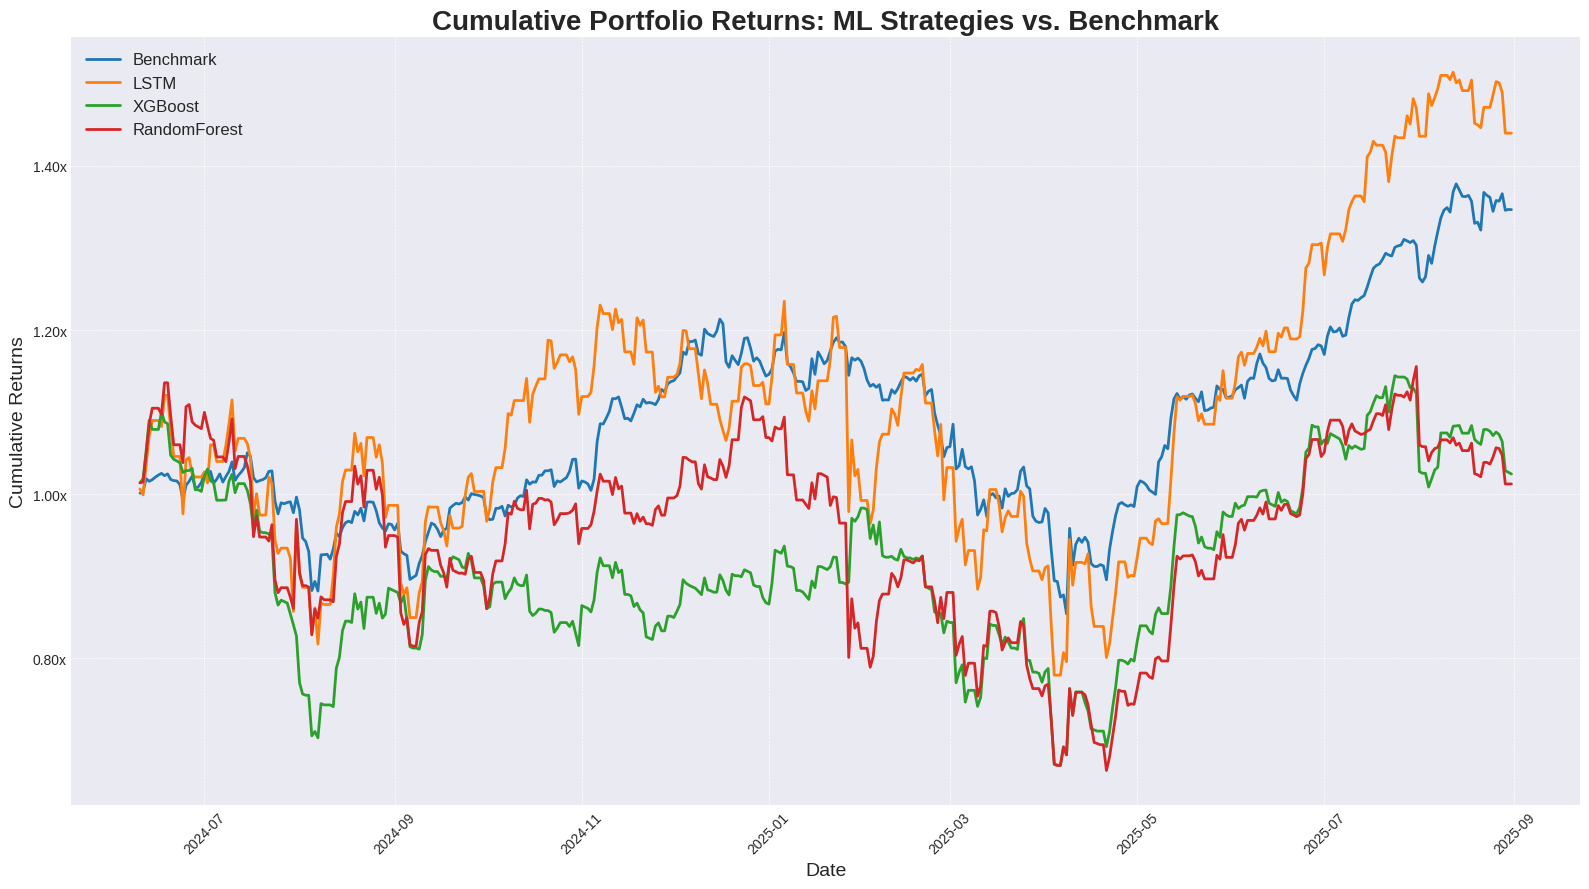


--- Phase 5 Complete: Project implementation is finished. ---


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Phase 5: Performance Evaluation ---

# This script assumes 'portfolio_returns' from Phase 4 is in memory.
# A fallback is included to make the script runnable standalone.

try:
    _ = portfolio_returns
    print("--- Using existing portfolio returns data from Phase 4 ---\n")
except NameError:
    print("--- Portfolio returns not found. Re-running all previous phases ---")
    # This will take a significant amount of time as it retrains all models.
    exec(open('phase_1_data_preprocessing.py').read())
    exec(open('phase_2_feature_engineering.py').read())
    exec(open('phase_3_model_development.py').read())
    exec(open('phase_4_backtesting.py').read())
    print("--- Environment re-initialized successfully ---\n")


# --- 1. Calculate Performance Metrics ---
print("--- Calculating Performance Metrics for All Strategies ---")

# The number of trading days in a year
TRADING_DAYS_PER_YEAR = 252

# A small constant to avoid division by zero in Sortino Ratio
EPSILON = 1e-9

# Create a DataFrame to store the calculated metrics
performance_metrics = pd.DataFrame(index=portfolio_returns.columns)

for strategy in portfolio_returns.columns:
    daily_returns = portfolio_returns[strategy]

    # Cumulative Returns
    cumulative_returns = (1 + daily_returns).cumprod()
    total_return = cumulative_returns.iloc[-1] - 1

    # Annualized Volatility
    annualized_volatility = daily_returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)

    # Annualized Sharpe Ratio (assuming risk-free rate is 0)
    sharpe_ratio = (daily_returns.mean() * TRADING_DAYS_PER_YEAR) / (annualized_volatility + EPSILON)

    # Maximum Drawdown
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # Sortino Ratio
    negative_returns = daily_returns[daily_returns < 0]
    downside_deviation = negative_returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
    sortino_ratio = (daily_returns.mean() * TRADING_DAYS_PER_YEAR) / (downside_deviation + EPSILON)

    # Calmar Ratio
    calmar_ratio = (daily_returns.mean() * TRADING_DAYS_PER_YEAR) / (abs(max_drawdown) + EPSILON)

    # Store metrics
    performance_metrics.loc[strategy, 'Total Return'] = f"{total_return:.2%}"
    performance_metrics.loc[strategy, 'Annualized Volatility'] = f"{annualized_volatility:.2%}"
    performance_metrics.loc[strategy, 'Sharpe Ratio'] = f"{sharpe_ratio:.2f}"
    performance_metrics.loc[strategy, 'Sortino Ratio'] = f"{sortino_ratio:.2f}"
    performance_metrics.loc[strategy, 'Calmar Ratio'] = f"{calmar_ratio:.2f}"
    performance_metrics.loc[strategy, 'Max Drawdown'] = f"{max_drawdown:.2%}"


print("\n--- Performance Metrics Summary ---")
print(performance_metrics)
print("\n" + "="*70 + "\n")


# --- 2. Visualize Cumulative Returns ---
print("--- Generating Cumulative Returns Plot ---")

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(16, 9))

# Calculate cumulative returns for plotting
cumulative_returns_plot = (1 + portfolio_returns).cumprod()

for strategy in cumulative_returns_plot.columns:
    ax.plot(cumulative_returns_plot.index, cumulative_returns_plot[strategy], label=strategy, linewidth=2)

ax.set_title('Cumulative Portfolio Returns: ML Strategies vs. Benchmark', fontsize=20, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Cumulative Returns', fontsize=14)
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Format y-axis to show growth factor (e.g., 1.5x)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}x'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n--- Phase 5 Complete: Project implementation is finished. ---")
